<a href="https://colab.research.google.com/github/jlee92603/BrainTumor_CNN_Model/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations


In [ ]:
!pip install google-api-python-client

In [ ]:
!pip install opencv-python-headless

In [ ]:
pip install keras-metrics

In [ ]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=294396187d96014087731014d99fc699b70641185c7e8df0bd9285517a296db1
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# Connect Drive and Import Libraries

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# upload image data
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import io
from googleapiclient.http import MediaIoBaseUpload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from os import listdir
from tabulate import tabulate
import numpy as np
import math
import cv2
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Activation, MaxPooling2D, Conv2D, Attention, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Model, Sequential
from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam, SGD, AdamW, Adamax, Adagrad
from keras.callbacks import ModelCheckpoint
from keras.losses import CategoricalFocalCrossentropy, CategoricalHinge, SparseCategoricalCrossentropy

In [ ]:
import seaborn as sn
from scipy import interp
from itertools import cycle
import sklearn
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# find GPU
from tensorflow import test
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# test GPU
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.480433758999425
GPU (s):
0.10104755899919837
GPU speedup over CPU: 83x


# Upload and Read Images

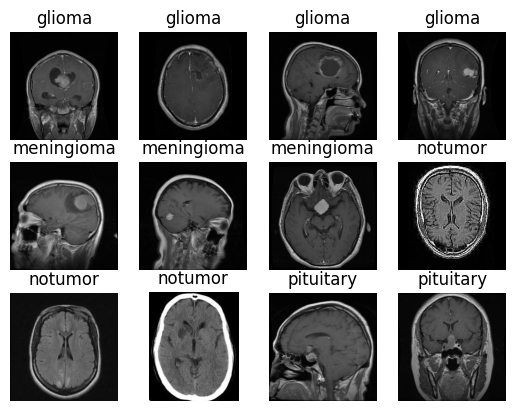

+-----+-------------------+--------------+
|   # | image file name   | tumor type   |
+=====+===================+==============+
|   0 | Tr-gl_0705.jpg    | glioma       |
+-----+-------------------+--------------+
|   1 | Tr-gl_0567.jpg    | glioma       |
+-----+-------------------+--------------+
|   2 | Tr-gl_0305.jpg    | glioma       |
+-----+-------------------+--------------+
|   3 | Tr-me_0845.jpg    | meningioma   |
+-----+-------------------+--------------+
|   4 | Tr-me_1116.jpg    | meningioma   |
+-----+-------------------+--------------+
|   5 | Tr-me_1171.jpg    | meningioma   |
+-----+-------------------+--------------+
|   6 | Tr-no_0523.jpg    | notumor      |
+-----+-------------------+--------------+
|   7 | Tr-no_0703.jpg    | notumor      |
+-----+-------------------+--------------+
|   8 | Tr-no_0835.jpg    | notumor      |
+-----+-------------------+--------------+
|   9 | Tr-pi_0804.jpg    | pituitary    |
+-----+-------------------+--------------+
|  10 | Tr-

In [ ]:
# data path from drive
filepath = '/content/drive/MyDrive/0 Lee Lab/brain tumor classification model/'
training_data_path = filepath + 'brain tumor image files/archive/Training'
testing_data_path = filepath + 'brain tumor image files/archive/Testing'

# load the file names of the images in multiple folders
def load_images_files_from_folder(directory):
    image_files = []
    file_labels = []

    # for each folder in directory
    for folder in os.listdir(directory):
      # for each file in each folder in directory
      for file in os.listdir(os.path.join(directory,folder)):
        # add file if it ends with .jpg
        if file.endswith(".jpg"):
            file_name = os.path.join(directory, folder, file)
            if image_files is not None:
                image_files.append(file_name)
                file_labels.append(folder)

    # returns tumor image file names and types of tumor they are
    return image_files, file_labels

# access images from multiple folders
image_files, file_labels = load_images_files_from_folder(training_data_path)
test_image_files, test_file_labels = load_images_files_from_folder(testing_data_path)

# display couple images
fig, ax = plt.subplots(3,4)
for x in range(12):
  img = cv2.imread(image_files[x*430],1)
  ax[int(x/4),int(x%4)].set_title(os.path.basename(os.path.dirname(image_files[x*430])))
  ax[int(x/4),int(x%4)].imshow(img)
  ax[int(x/4),int(x%4)].axis("off")
plt.show()

# format information in a table
header = ["#", "image file name", "tumor type"]
data = []

for ct, ele in enumerate(image_files[0:3]):
  data.append([ct, os.path.basename(ele), os.path.basename(os.path.dirname(ele))])

for ct, ele in enumerate(image_files[2000:2003]):
  data.append([ct+3, os.path.basename(ele), os.path.basename(os.path.dirname(ele))])

for ct, ele in enumerate(image_files[3000:3003]):
  data.append([ct+6, os.path.basename(ele), os.path.basename(os.path.dirname(ele))])

for ct, ele in enumerate(image_files[5000:5003]):
  data.append([ct+9, os.path.basename(ele), os.path.basename(os.path.dirname(ele))])

print(tabulate(data, header, tablefmt="grid"))

# Split and Concatenate Data

In [ ]:
# data concatenation as data frame
# inputs: image_files is the path to jpg image; image_file_labels is corresponding image label
# returns: dataframe of image files and their labels
def concatenateDataAsDF(image_files, image_file_labels):
  Fseries = pd.Series(image_files , name = 'filepaths')
  Lseries = pd.Series(image_file_labels , name = 'label')
  return pd.concat([Fseries , Lseries] , axis = 1)


In [ ]:
# concatenate training data as data frame
train_df = concatenateDataAsDF(image_files, file_labels)
train_df # training data as a data frame


,filepaths,label
0,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
1,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
2,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
3,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
4,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
...,...,...
5747,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,pituitary
5748,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,pituitary
5749,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,pituitary
5750,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,pituitary


In [ ]:
# concatenate testing data as data frame
test_df = concatenateDataAsDF(test_image_files,test_file_labels)
test_df # testing data as a data frame


,filepaths,label
0,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,meningioma
1,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,meningioma
2,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,meningioma
3,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,meningioma
4,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,meningioma
...,...,...
1306,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
1307,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
1308,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma
1309,/content/drive/MyDrive/0 Lee Lab/brain tumor c...,glioma


In [ ]:
# separate validation data from training data
valid_data, train_data = train_test_split(train_df, train_size=0.3, shuffle=True, random_state=42)


In [ ]:
# ImageDataGenerator (generate tensor image data)
# IDG class ensures model receives new variations of images at each epoch
# takes inputs and randomly transforms it (flip, shift, rotate, brighten, etc)

img_size = (224 ,224) # size of image
batch_size = 4 # ImageDataGenerator produces 4 images each iteration of training

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

# flow_from_dataframe takes dataframe+directory path to generate bathes
# color_mode = grayscale

train_gen = tr_gen.flow_from_dataframe(train_data , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical' , color_mode = 'grayscale' , shuffle = True , batch_size =batch_size)

valid_gen = tr_gen.flow_from_dataframe(valid_data , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical',color_mode = 'grayscale' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical' , color_mode= 'grayscale' , shuffle = False , batch_size = batch_size)



Found 4027 validated image filenames belonging to 4 classes.
Found 1725 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# Functions for CNN w Keras

## 1. Initialize CNN: Add Layers, Pooling, Flattening Operations

> Conv2D: 5 arguments in a convolutional layer
-  conv layer convolves input by moving filters along input vertically and horizontally and computing dot product of the weigths and input w bias
1. Filters: dimension of output space; feature detector; important in identifying various features; benefits include improved feature extraction, enhanced generalization, and greater discriminative power; drawbacks include increased computational cost, risk of overfitting, and a need for more data
2. Kernel size: filter matrix size (2*2) [2D conv window]; increasing kernel size allows it to capture more global features from input image
3. Padding: adds extra pixels around input image to prevent spatical shrinking; makes sure edges are not lost; "same" results in padding with zeros evenly to L/R or up/down of input
4. Activation Function: ReLU; network learns non-linear relationships between input/output
5. Input shape: (rows, cols, channels); there is 1 channel in grayscale image

> Max Pooling: operation that calcualtes max value for patches of feature mape to create a downsampled (pooled) feature map; reduces dimensions while preserving most relevant features in local region, reduces overfitting, computationally efficient

> Flattening: to put data into a 1D array for input into next layer

> Dense: layer that contains all neurons that are deeply connected within themselves; Dense is useful when association can exist among any feature to any other feature in data point; conv layers are useful when neighborhoods (nearby associations) matter to classify or detect features

In [ ]:
# create the convolutional neural network model
# inputs: filters is a list of filter values for each of the Conv2D layers; default=[16,32,64]
# returns: keras CNN model with Con2D, MaxPooling2D, and Dense layers

def createModel(filters=[16,32,64]):

  # initialize CNN
  model = Sequential() # Sequential Model consists of sequence of layers

  # add first convolution layer
  model.add(Conv2D(filters=filters[0],kernel_size=2,padding="same",activation="relu",input_shape=(224,224,1)))

  # max pooling operation
  model.add(MaxPooling2D(pool_size=2))

  # add more layers (Conv2D and MaxPool)
  for filter in filters[1:]:
    model.add(Conv2D(filters=filter,kernel_size=2,padding="same",activation ="relu"))
    model.add(MaxPooling2D(pool_size=2))

  # flattening operation (convert data into 1D array for input into next layer)
  model.add(Flatten())

  # fully connected layer and ouput layer; input units: dimension of output
  model.add(Dense(500,activation="relu")) # 250; 150 # variation of num of filters
  model.add(Dense(4,activation="softmax")) # 4 categories

  # softmax is similar to sigmoid; has smaller variance than relu
  (model.summary())

  return model


## 2. Compile CNN Model, Fit Model

In [ ]:
# compile CNN model
# inputs:
#   model created from createModel
#   loss is loss function; default is 'categorical_crossentropy'
#   optimizer with learning rate; default is Adam(learning_rate=0.001)
#   metrics is type of metrics used to evaluate data; default is Recall
# returns: compliation and fitting/training of model on training and validation data

def compileModel(model, filepath, optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                 metrics=[keras.metrics.Recall()], shuffle=False):

  # loss function
  model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

  # model check point
  checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_recall',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

  # fit model on training set
  # epoch: number of times the learning algorithm will work through the entire training dataset
  return model.fit(x=train_gen, epochs=10, callbacks=checkpoint, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=shuffle)


## 3. Evaluate Results

In [ ]:
# test model of best epoch on testing data
# inputs:
#   filepath where model of best epoch is saved
#   test_data is test data as ImageDataGenerator from DataFrame
# returns: prediction values
def testModel(filepath, test_data=test_gen):
  bestModel = keras.models.load_model(filepath)
  pred = bestModel.predict(test_data)
  y_pred = np.argmax(pred, axis=1)
  return y_pred

# plot the losses and recall for the training and validation data
# inputs: cnn_model is fitted model; saveAs is name of plot to be saved
# returns: plots loss and recall graphs for training and validation data
def plotResults(cnn_model, saveAs=False, filepath=filepath):
  fig, ax = plt.subplots(1,2)

  # plot loss graph
  ax[0].set_title("Loss Graph")
  ax[0].plot(cnn_model.history['loss'], label='train loss')
  ax[0].plot(cnn_model.history['val_loss'], label='val loss')
  ax[0].legend()

  # plot recall graph
  ax[1].set_title("Recall Graph")
  ax[1].plot(cnn_model.history['recall'], label='train recall')
  ax[1].plot(cnn_model.history['val_recall'], label='val recall')
  ax[1].legend()

  plt.tight_layout()
  if saveAs!=False:
    plt.savefig(filepath + saveAs)

  plt.show()

# create and plot confusion matrix
# inputs: y_pred is prediction values; saveAs is name of plot to be saved
# returns: plots confusion matrix for testing data
def createConfusionMatrix(y_pred, saveAs=False, filepath=filepath, test_gen=test_gen):
  # create confusion matrix with sklearn.metrics
  # classes is the actual values 0,1,2,3 corresponding to each type of tumor
  conf_mat = sklearn.metrics.confusion_matrix(test_gen.classes, y_pred)

  # use seaborn heatmap to plot confusion matrix
  # change resulting confusion matrix to data frame
  confusion_matrix_df = pd.DataFrame(conf_mat)

  sn.set(font_scale=1)
  cm_plot = sn.heatmap(confusion_matrix_df, annot=True, fmt="1.0f", linewidth=0.5,
                                cmap=sn.cubehelix_palette(as_cmap=True))

  cm_plot.set_xticklabels(list(test_gen.class_indices.keys()), rotation=45)
  cm_plot.set_yticklabels(list(test_gen.class_indices.keys()), rotation=0)

  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')

  if saveAs!=False:
    plt.savefig(filepath + saveAs, bbox_inches='tight')

  plt.show()


In [ ]:
# data needs to be binarized; for all types of tumor, set no tumor as 0, tumor as 1
# inputs:
#   y_pred is predicted values for testing data
#   tumorValue is number assigned to categorical label (glioma, meningioma, noTumor, pituitary)
#   test_gen is testing data
# returns: binarized actual values, binarized predicted values

def binarizePredictions(y_pred, tumorValue, test_gen=test_gen):
  # tumorValue: 0 for glioma, 1 for meningioma, 2 for noTumor, 3 for pituitary

  binarized_actual = [] # actual values for specific tumor or not
  binarized_predicted = [] # predicted values for specific tumor or not

  # for each value in actual value, if it is a value for specific tumor class,
  # add it to array and add the corresponding prediction to array
  for j in range(len(test_gen.classes)):
    actual_val = test_gen.classes[j]
    pred_val = y_pred[j]

    # if no tumor, append 0 as actual value
    if actual_val == 2:
      binarized_actual.append(0)
      # no tumor correctly predicted or not
      if pred_val == 2:
        binarized_predicted.append(0)
      else:
        binarized_predicted.append(1)

    # if tumor, append 1 as actual value
    if actual_val==i:
      binarized_actual.append(1)
      # tumor correctly predicted or not
      if pred_val == i:
        binarized_predicted.append(1)
      else:
        binarized_predicted.append(0)

  return binarized_actual, binarized_predicted

# calculate precision and recall values
# inputs: binarized_actual, binarized_predicted
# returns: precision, recall
def calcPrecisionRecall(binarized_actual, binarized_predicted):

  # true positive, false positive, false negative
  TP = 0
  FP = 0
  FN = 0

  # find whether TF, FP, or FN based on predictions
  for i in range(len(binarized_actual)):
    if binarized_actual[i]==binarized_predicted[i]==1:
      TP+=1
    if binarized_actual[i]==0 and binarized_predicted[i]==0:
      FP+=1
    if binarized_actual[i]==1 and binarized_predicted[i]==0:
      FN+=1

  # set precision and recall to 1
  precision = 1
  recall = 1

  # calculate precision and recall if denominator isn't 0
  if TP+FP != 0:
    precision = TP / (TP+FP)
  if TP+FN != 0:
    recall = TP / (TP+FN)

  return precision, recall



```
# GLIOMA
actual_glioma, predicted_glioma = binarizePredictions(y_pred=y_pred, tumorValue=0) # glioma

# ROC curve
fpr, tpr, thresholds = roc_curve(actual_glioma, predicted_glioma)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

# PR Curve
precision, recall, _ = precision_recall_curve(actual_glioma, predicted_glioma)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()

# MENINGIOMA
actual_meningioma, predicted_meningioma = binarizePredictions(y_pred=y_pred, tumorValue=1) # meningioma

# ROC curve
fpr, tpr, thresholds = roc_curve(actual_meningioma, predicted_meningioma)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

# PR Curve
precision, recall, _ = precision_recall_curve(actual_meningioma, predicted_meningioma)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()

#pr_display.figure_.savefig('')
#roc_display.figure_.savefig('')
```





```
# create ROC curve
# compute ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)-1):
    fpr[i], tpr[i], _ = roc_curve(y[i], yPred[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curve
plt.figure(1)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(len(classes)-1), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(noTumorClasses[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC MultiClass')
plt.legend(loc="lower right")
plt.show()

# plotted over different thresholds (typically 0.5)
# each point corresponds to different values of threshold

# create precision recall curve

for i in range(len(classes)-1):
  precision, recall, _ = precision_recall_curve(y[i], yPred[i])
  pr_curve = PrecisionRecallDisplay(precision=precision, recall=recall)
  pr_curve.plot()
  plt.title("PR Curve of " + noTumorClasses[i])
```



## Clear Session

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

## Gather Results

In [ ]:
# create empty lists to store all the loss/recall graphs and confusion matrices
recall_graphs = []
conf_matrices = []

# create empty list to store the results of each model
results = [] # [cohort, best recall, optimizer, learning_rate, loss_function, filters, other]
heading = ['Cohort','Best Recall Values', 'Optimizer', 'Learning Rate', 'Loss Function', 'Filters', 'Other']


In [ ]:
# function to plot all the graphs collected from each model
# inputs: conf_matrices has confusion matrices; recall_graphs has loss/recall graphs
# outputs: subplot of confusion matrices and loss/recall graphs
def plotAllGraphs(conf_matrices, recall_graphs, filepath=filepath):
  plt.figure(figsize=(20,80))
  row = len(conf_matrices)
  col = 2

  for i in range(row*col):
    plt.subplot(row, col, i+1)
    plt.axis('off')
    if i%2!=0:
      plt.title(conf_matrices[i//2],fontsize=20)
      plt.imshow(mpimg.imread(filepath+conf_matrices[i//2]+'.png'))
    else:
      plt.title(recall_graphs[i//2],fontsize=20)
      plt.imshow(mpimg.imread(filepath+recall_graphs[i//2]+'.png'))


# CNN: Convolutional Neural Network [A]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_23 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)


328/328 [==============================] - 5s 14ms/step


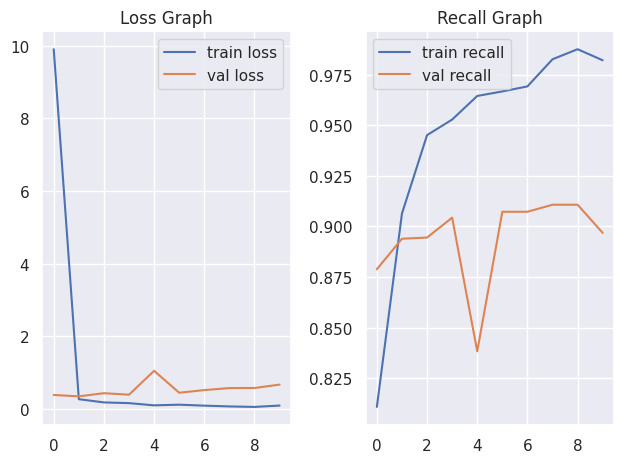

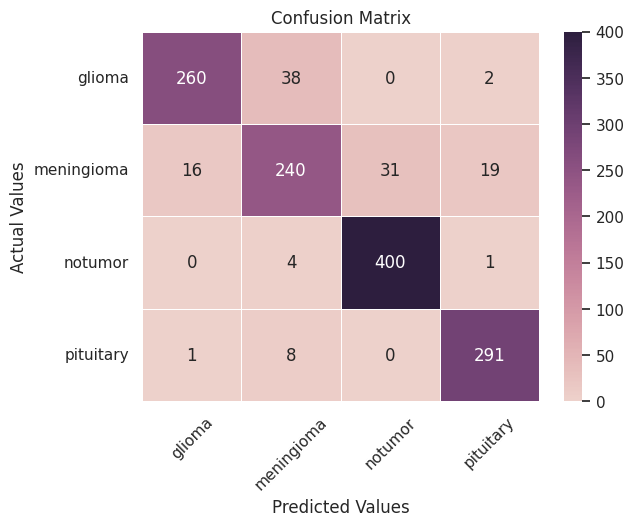

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort A Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort A Confusion Matrix')

# save results
conf_matrices.append('Cohort A Confusion Matrix')
recall_graphs.append('Cohort A Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['A', highest_recall, 'Adam', 0.001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Learning Rate 0.01 [B]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.01))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 5s 16ms/step


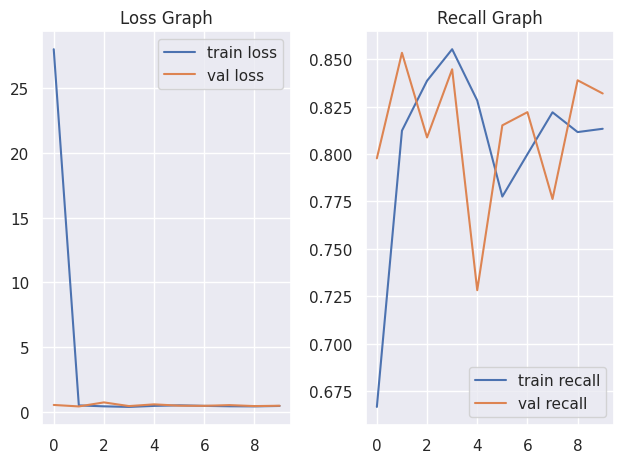

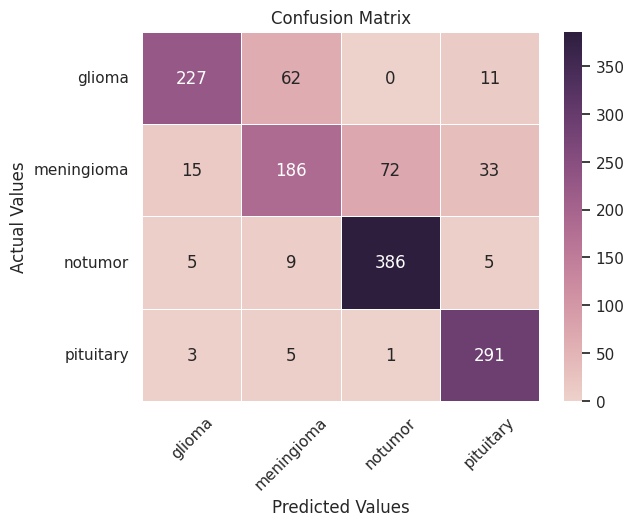

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort B Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort B Confusion Matrix')

# save results
conf_matrices.append('Cohort B Confusion Matrix')
recall_graphs.append('Cohort B Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['B', highest_recall, 'Adam', 0.01, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Learning Rate 0.0001 [C]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 5s 16ms/step


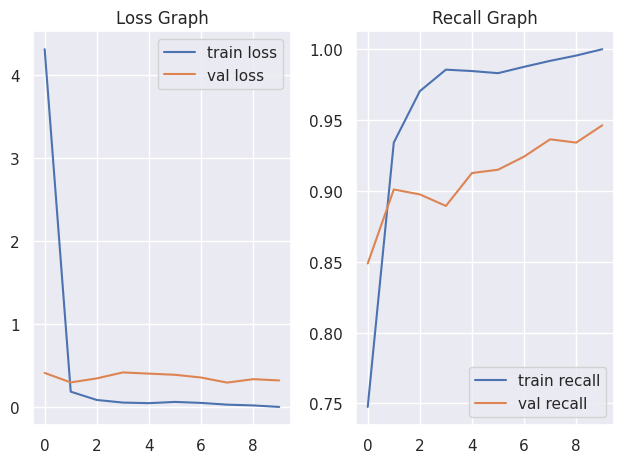

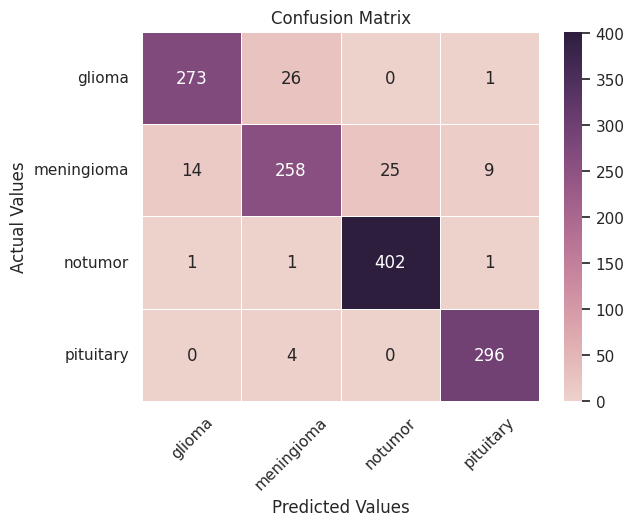

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort C Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort C Confusion Matrix')

# save results
conf_matrices.append('Cohort C Confusion Matrix')
recall_graphs.append('Cohort C Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['C', highest_recall, 'Adam', 0.0001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: All Filters = 32 [D]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[32,32,32]
model = createModel(filters=[32,32,32])

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

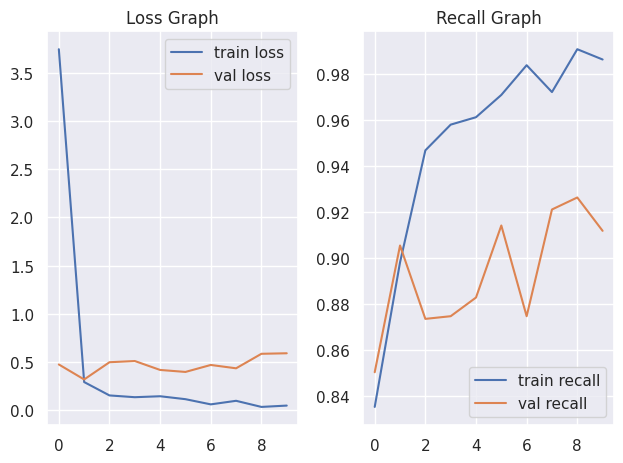

328/328 [==============================] - 5s 16ms/step


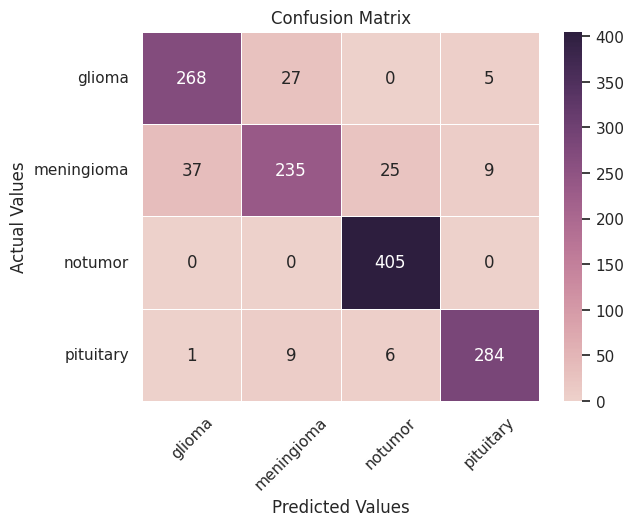

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort D Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort D Confusion Matrix')

# save results
conf_matrices.append('Cohort D Confusion Matrix')
recall_graphs.append('Cohort D Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['D', highest_recall, 'Adam', 0.001, 'categorical crossentropy', '32, 32, 32', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Add Another Layer [E]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,32,16]
model = createModel(filters=[16,32,32,64])

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 5s 16ms/step


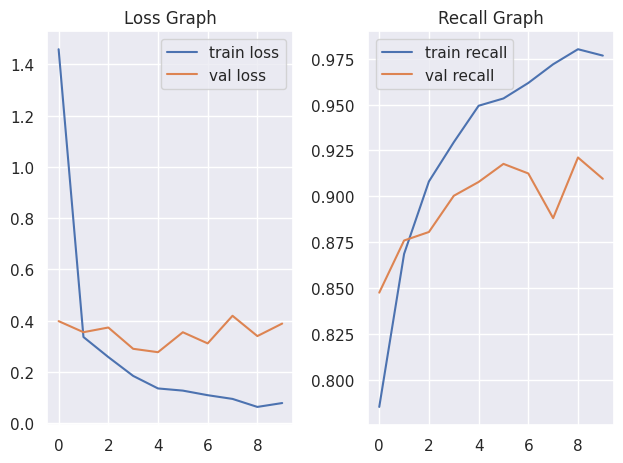

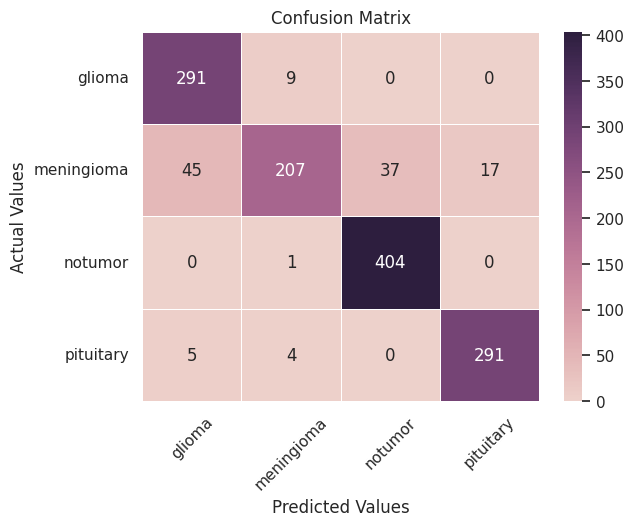

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort E Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort E Confusion Matrix')

# save results
conf_matrices.append('Cohort E Confusion Matrix')
recall_graphs.append('Cohort E Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['E', highest_recall, 'Adam', 0.001, 'categorical crossentropy', '16,32,32,16', 'Another Layer'])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Optimizer AdamW [F]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=AdamW(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 4s 12ms/step


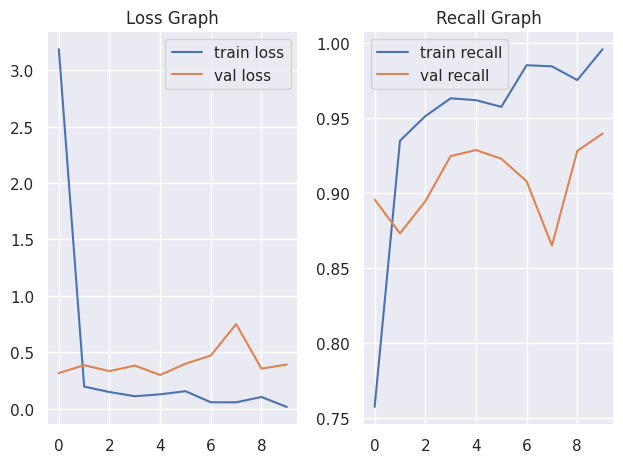

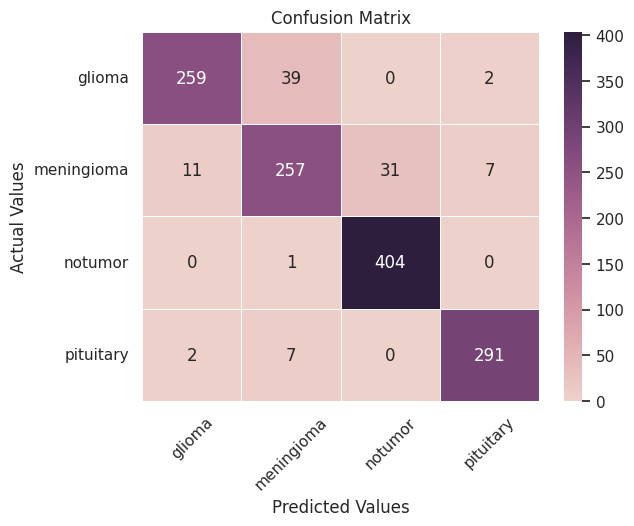

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort F Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort F Confusion Matrix')

# save results
conf_matrices.append('Cohort F Confusion Matrix')
recall_graphs.append('Cohort F Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['F', highest_recall, 'AdamW', 0.001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Optimizer SGD [G]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=SGD(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 4s 13ms/step


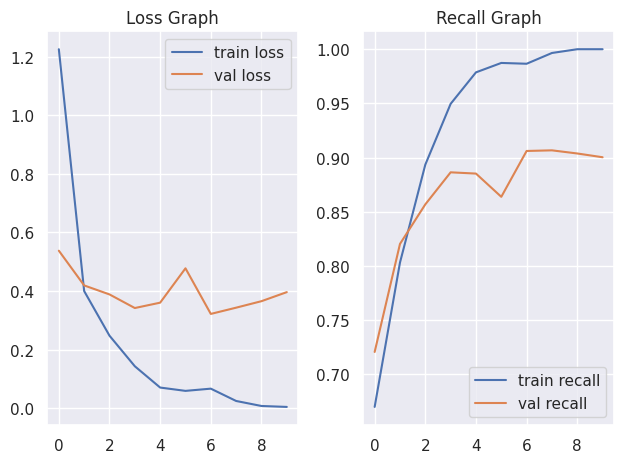

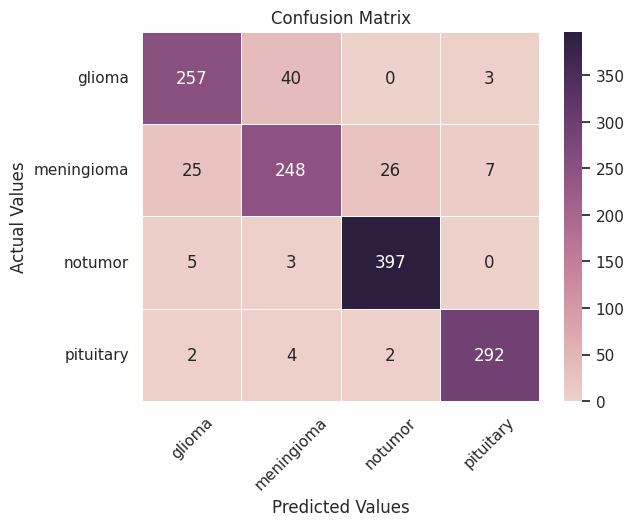

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort G Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort G Confusion Matrix')

# save results
conf_matrices.append('Cohort G Confusion Matrix')
recall_graphs.append('Cohort G Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['G', highest_recall, 'SGD', 0.001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Optimizer Adamax [H]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adamax(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 5s 14ms/step


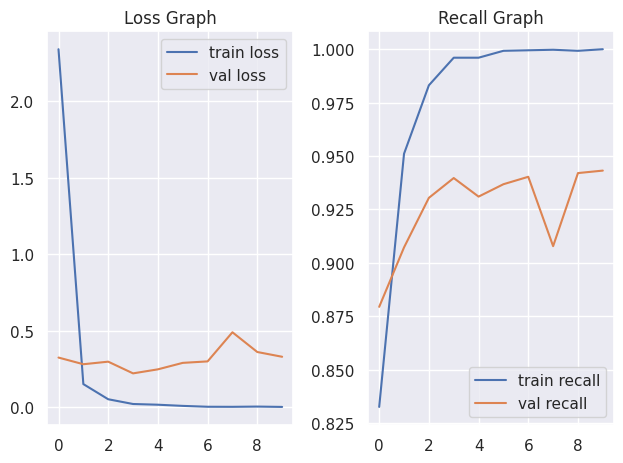

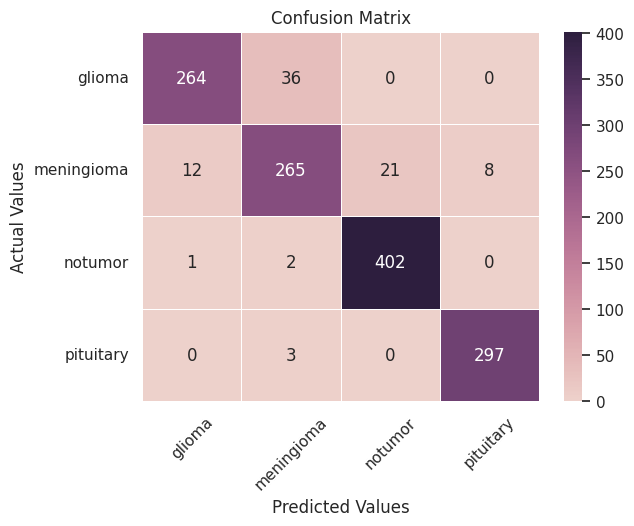

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort H Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort H Confusion Matrix')

# save results
conf_matrices.append('Cohort H Confusion Matrix')
recall_graphs.append('Cohort H Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['H', highest_recall, 'Adamax', 0.001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

In [ ]:
results

[['A',
  0.9107246398925781,
  'categorical crossentropy',
  0.001,
  'Adam',
  '16, 32, 64',
  None],
 ['A',
  0.9107246398925781,
  'categorical crossentropy',
  0.001,
  'Adam',
  '16, 32, 64',
  None],
 ['A',
  0.9107246398925781,
  'categorical crossentropy',
  0.001,
  'Adam',
  '16, 32, 64',
  None],
 ['N',
  0.9049275517463684,
  'categorical crossentropy',
  0.001,
  'Adam',
  '16, 32, 64',
  None],
 ['I',
  0.9420289993286133,
  'categorical crossentropy',
  0.001,
  'Adamax',
  '16, 32, 64',
  None],
 ['H',
  0.9431884288787842,
  'categorical crossentropy',
  0.001,
  'Adamax',
  '16, 32, 64',
  None]]

# CNN: Optimizer Adamax Learning Rate 0.0001 [I]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.0001)
cnn_model = compileModel(model, filepath, optimizer=Adamax(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 5s 14ms/step


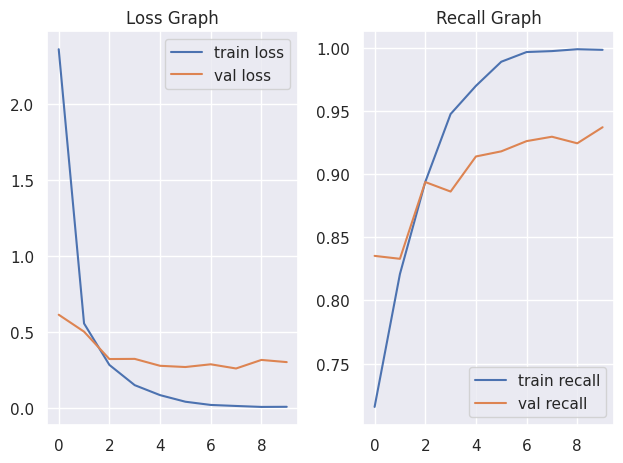

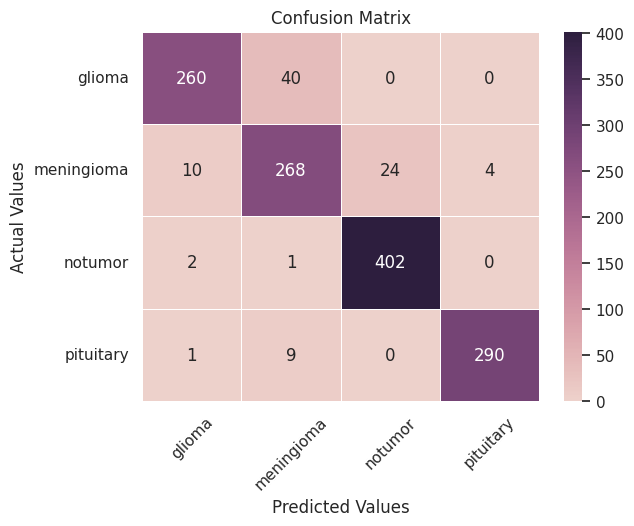

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort I Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort I Confusion Matrix')

# save results
conf_matrices.append('Cohort I Confusion Matrix')
recall_graphs.append('Cohort I Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['I', highest_recall, 'Adamax', 0.0001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Optimizer AdamW Learning Rate 0.0001 [J]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001)
cnn_model = compileModel(model, filepath, optimizer=AdamW(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 4s 12ms/step


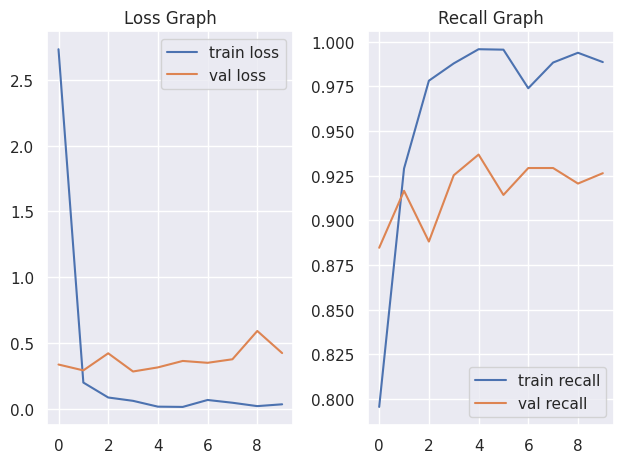

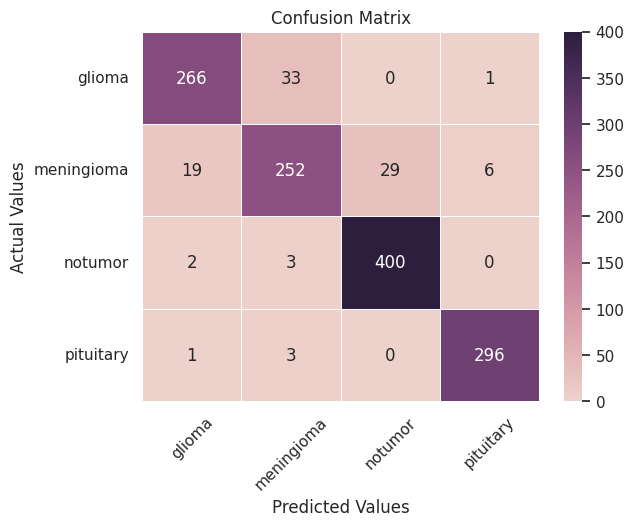

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort J Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort J Confusion Matrix')

# save results
conf_matrices.append('Cohort J Confusion Matrix')
recall_graphs.append('Cohort J Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['J', highest_recall, 'AdamW', 0.0001, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Optimizer Adamax Learning Rate 0.0005 [K]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.0005)
cnn_model = compileModel(model, filepath, optimizer=Adamax(learning_rate=0.0005))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 4s 13ms/step


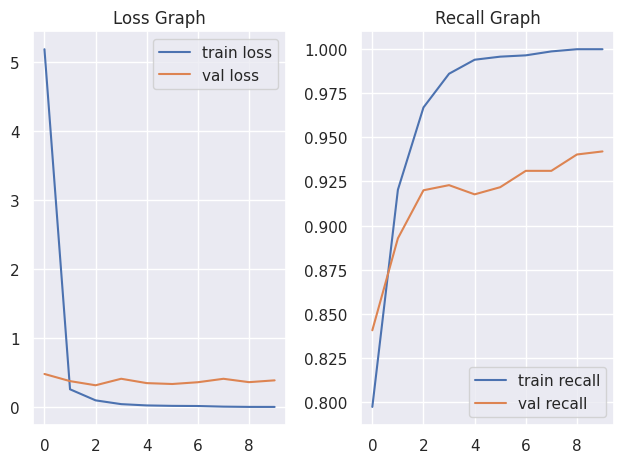

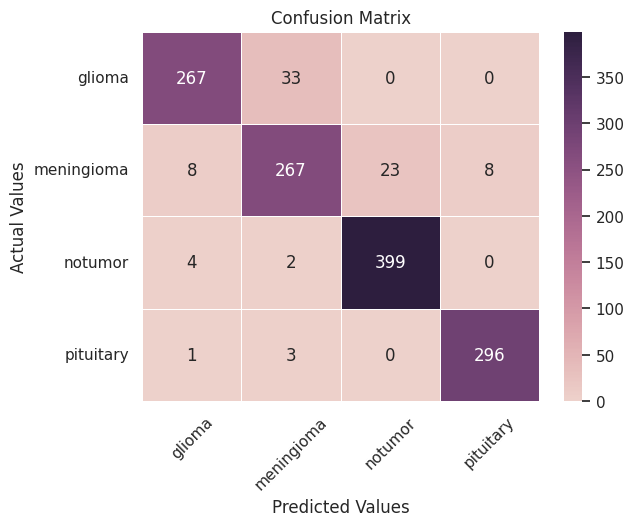

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort K Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort K Confusion Matrix')

# save results
conf_matrices.append('Cohort K Confusion Matrix')
recall_graphs.append('Cohort K Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['K', highest_recall, 'Adamax', 0.0005, 'categorical crossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Loss Function CategoricalFocalCrossentropy [L]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='CategoricalFocalCrossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001),loss=CategoricalFocalCrossentropy())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 4s 13ms/step


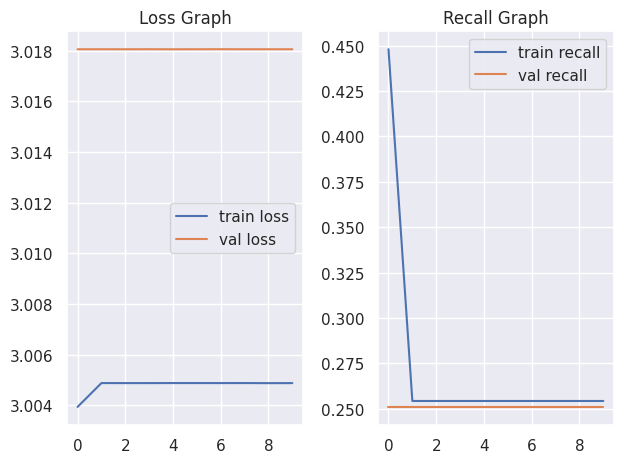

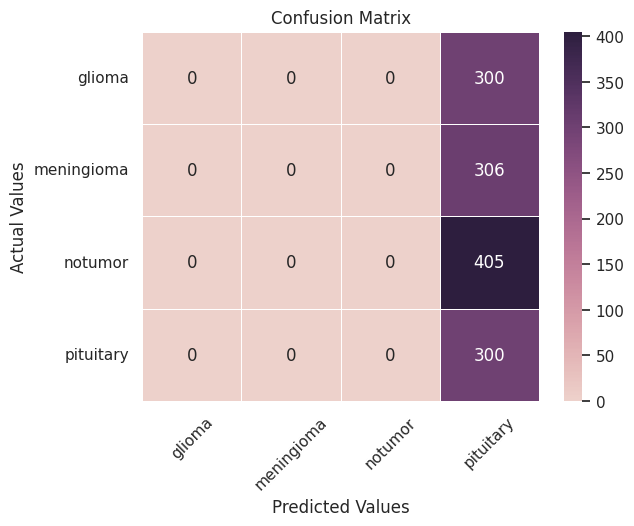

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort L Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort L Confusion Matrix')

# save results
conf_matrices.append('Cohort L Confusion Matrix')
recall_graphs.append('Cohort L Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['L', highest_recall, 'Adam', 0.001, 'CategoricalFocalCrossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Loss Function SparseCategoricalCrossentropy [M]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
from keras.losses import CosineSimilarity
model = createModel()

# compile model # loss='CosineSimilarity', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 28, 28, 64)       

InvalidArgumentError: ignored

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort M Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort M Confusion Matrix')

# save results
conf_matrices.append('Cohort M Confusion Matrix')
recall_graphs.append('Cohort M Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['M', highest_recall, 'Adam', 0.001, 'SparseCategoricalCrossentropy', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Add Attention Layer [N]

In [ ]:
# CREATE AND COMPILE MODEL
# create model with attention layer
inputs = Input((224,224,1))

conv1 = Conv2D(filters=16,kernel_size=2,padding="same",activation="relu")(inputs)
maxpool1 = MaxPooling2D(pool_size=2)(conv1)

conv2 = Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=2)(conv2)

conv3 = Conv2D(filters=64,kernel_size=2,padding="same",activation="relu")(maxpool2)
maxpool3 = MaxPooling2D(pool_size=2)(conv3)

attn = Attention()([maxpool3, maxpool3])

flattented = Flatten()(attn)

dense = Dense(500,activation="relu")(flattented)
final = Dense(4,activation="softmax")(dense)

model = Model(inputs=inputs, outputs=final)

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001))

Epoch 1/10
1005/1007 [============================>.] - ETA: 0s - loss: 14.0201 - recall: 0.7561
Epoch 1: val_recall improved from -inf to 0.79362, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1007/1007 [==============================] - 30s 28ms/step - loss: 13.9961 - recall: 0.7564 - val_loss: 0.4507 - val_recall: 0.7936
Epoch 2/10
1007/1007 [==============================] - ETA: 0s - loss: 0.3948 - recall: 0.8421
Epoch 2: val_recall improved from 0.79362 to 0.81565, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1007/1007 [==============================] - 30s 30ms/step - loss: 0.3948 - recall: 0.8421 - val_loss: 0.4056 - val_recall: 0.8157
Epoch 3/10
1007/1007 [==============================] - ETA: 0s - loss: 0.2697 - recall: 0.9012
Epoch 3: val_recall improved from 0.81565 to 0.84870, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1007/1007 [=============================

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)


328/328 [==============================] - 5s 15ms/step


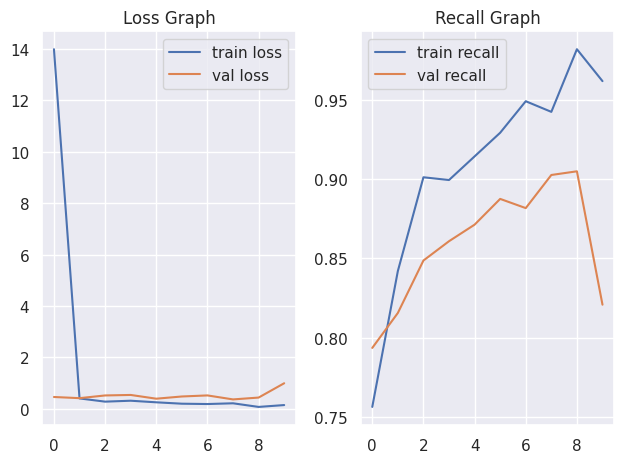

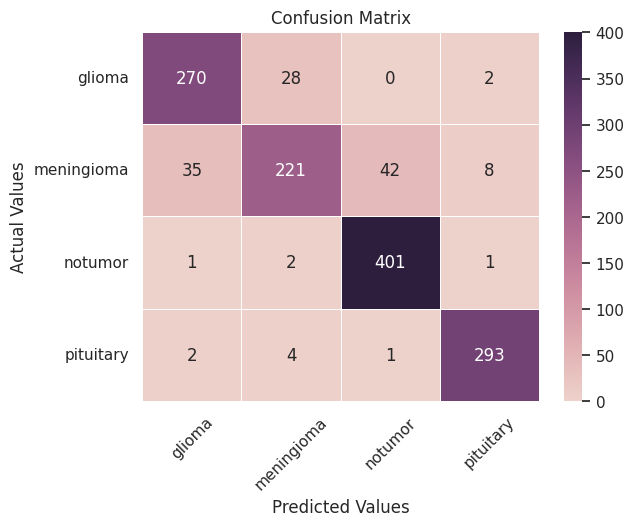

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort N Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort N Confusion Matrix')

# save results
conf_matrices.append('Cohort N Confusion Matrix')
recall_graphs.append('Cohort N Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['N', highest_recall, 'Adam', 0.001, 'categorical crossentropy', '16, 32, 64', 'Attention Layer'])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Shuffle=True [O]

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.0001), shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

328/328 [==============================] - 6s 19ms/step


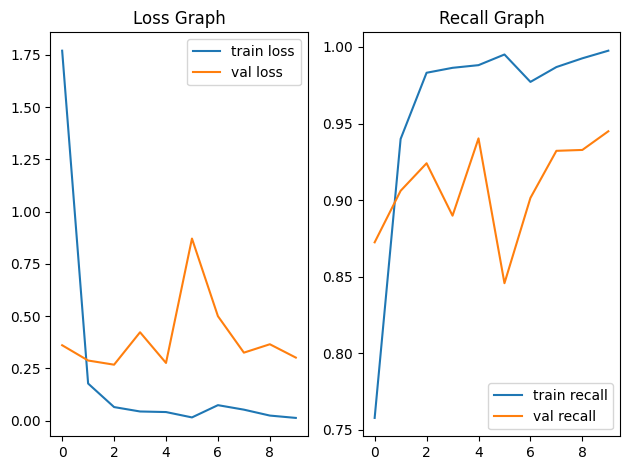

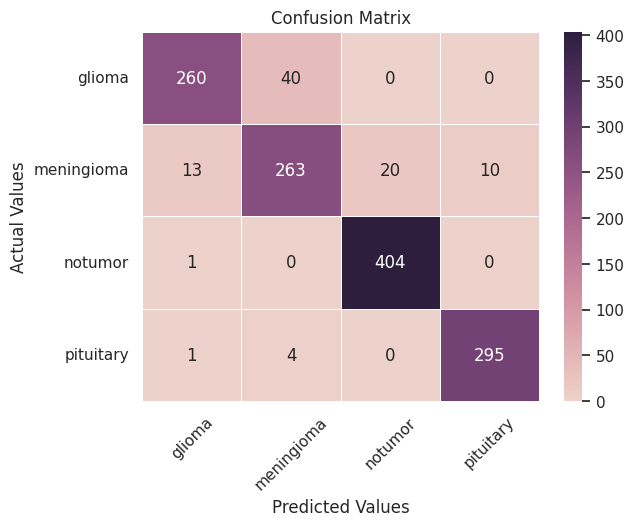

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort O Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort O Confusion Matrix')

# save results
conf_matrices.append('Cohort O Confusion Matrix')
recall_graphs.append('Cohort O Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['O', highest_recall, 'categorical crossentropy', 0.0001, 'Adam', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN: Keras EfficientNetB3 [Z]

In [ ]:
# ImageDataGenerator (generate tensor image data)
# IDG class ensures model receives new variations of images at each epoch
# takes inputs and randomly transforms it (flip, shift, rotate, brighten, etc)

img_size = (224 ,224) # size of image
batch_size = 4 # ImageDataGenerator produces 4 images each iteration of training

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

# flow_from_dataframe takes dataframe+directory path to generate bathes
# color_mode = rgb; channel must be 3
train_gen1 = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical' , color_mode = 'grayscale' , shuffle = True , batch_size =batch_size)

valid_gen1 = tr_gen.flow_from_dataframe(valid_data , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical',color_mode = 'grayscale' , shuffle= True, batch_size = batch_size)

test_gen1 = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , class_mode = 'categorical' , color_mode= 'grayscale' , shuffle = False , batch_size = batch_size)


Found 5752 validated image filenames belonging to 4 classes.
Found 1725 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
# CREATE MODEL
gen_dict = train_gen1.class_indices
classes = list(gen_dict.keys())

img_shape = (img_size[0] , img_size[1] , 3)
print(img_shape)
num_class = len(classes)

base_model = keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = [keras.metrics.Recall()])
model.summary()

(224, 224, 3)
43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11178035 (42.64 MB)
Trainable params: 11090732 (42.31 MB)
Non-trainable params: 87303 (341.03 KB)
_______________________________________________________________

In [ ]:
# FIT MODEL
# model check point
checkpoint = ModelCheckpoint(filepath=filepath,
                            monitor='val_recall',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

# fit model on training set
cnn_model = model.fit(x= train_gen1, epochs = 10, callbacks=checkpoint, verbose = 1, validation_data = valid_gen1,
                   validation_steps = None, shuffle = False)

Epoch 1/10
1438/1438 [==============================] - ETA: 0s - loss: 4.5498 - recall: 0.7111
Epoch 1: val_recall improved from -inf to 0.96174, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1438/1438 [==============================] - 285s 160ms/step - loss: 4.5498 - recall: 0.7111 - val_loss: 2.5054 - val_recall: 0.9617
Epoch 2/10
1438/1438 [==============================] - ETA: 0s - loss: 1.6114 - recall: 0.8943
Epoch 2: val_recall improved from 0.96174 to 0.98435, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1438/1438 [==============================] - 277s 192ms/step - loss: 1.6114 - recall: 0.8943 - val_loss: 0.7055 - val_recall: 0.9843
Epoch 3/10
1438/1438 [==============================] - ETA: 0s - loss: 0.5117 - recall: 0.9569
Epoch 3: val_recall improved from 0.98435 to 0.99420, saving model to /content/drive/MyDrive/0 Lee Lab/brain tumor classification model/
1438/1438 [===========================

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath,test_data=test_gen1)

328/328 [==============================] - 13s 32ms/step


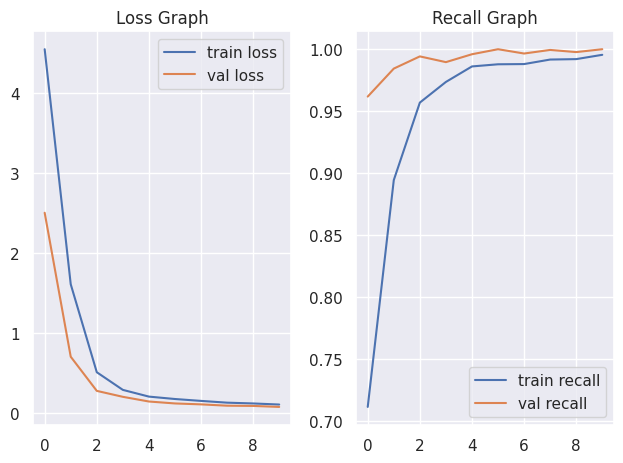

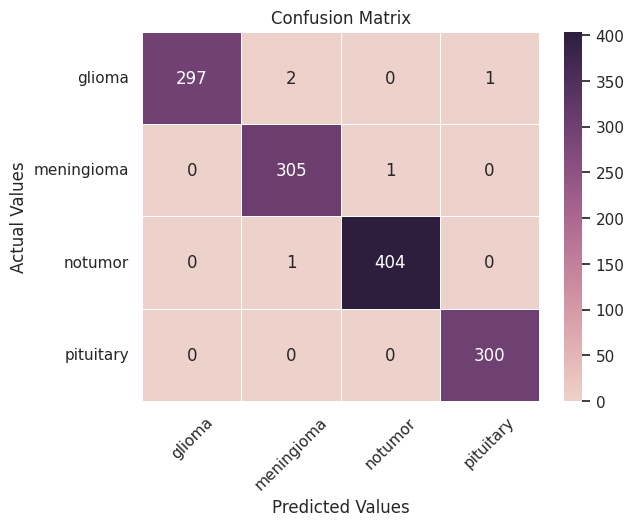

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort Z Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort Z Confusion Matrix')

# save results
conf_matrices.append('Cohort Z Confusion Matrix')
recall_graphs.append('Cohort Z Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['Z', highest_recall, 'Adamax', 0.001, 'categorical crossentropy', '...', 'EfficientNetB3'])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()

# CNN Model Comparisons



In [ ]:
# PRINT SAVED RESULTS
print(tabulate(results, heading, tablefmt="grid"))

+----------+----------------------+-------------+-----------------+--------------------------+-------------+-----------------+
| Cohort   |   Best Recall Values | Optimizer   |   Learning Rate | Loss Function            | Filters     | Other           |
+==========+======================+=============+=================+==========================+=============+=================+
| A        |             0.92058  | Adam        |          0.001  | categorical crossentropy | 16, 32, 64  |                 |
+----------+----------------------+-------------+-----------------+--------------------------+-------------+-----------------+
| B        |             0.853333 | Adam        |          0.01   | categorical crossentropy | 16, 32, 64  |                 |
+----------+----------------------+-------------+-----------------+--------------------------+-------------+-----------------+
| C        |             0.946087 | Adam        |          0.0001 | categorical crossentropy | 16, 32, 64  |   

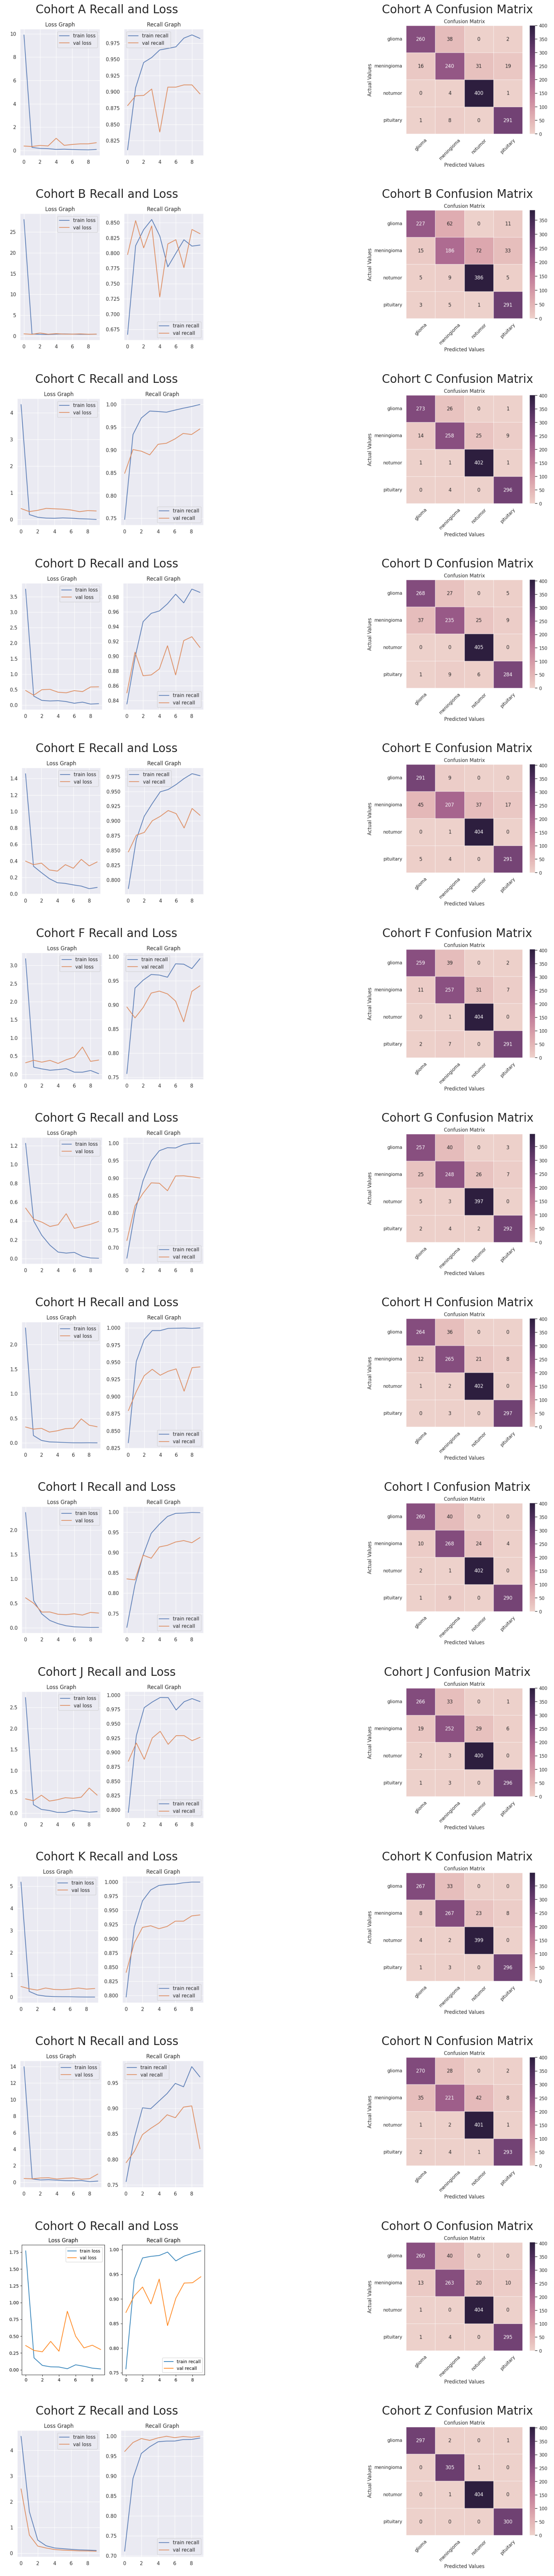

In [ ]:
plotAllGraphs(conf_matrices, recall_graphs)

# CNN: formatting

In [ ]:
# CREATE AND COMPILE MODEL
# create model # filters=[16,32,64]
model = createModel()

# compile model # loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001)
cnn_model = compileModel(model, filepath, optimizer=Adam(learning_rate=0.001))

In [ ]:
# TEST MODEL ON TESTING DATA
y_pred = testModel(filepath)

In [ ]:
# EVALUATE AND SAVE RESULTS
# evaluate results
plotResults(cnn_model, saveAs='Cohort A Recall and Loss')
createConfusionMatrix(y_pred, saveAs='Cohort A Confusion Matrix')

# save results
conf_matrices.append('Cohort A Confusion Matrix')
recall_graphs.append('Cohort A Recall and Loss')

highest_recall = max(cnn_model.history['val_recall'])
results.append(['A', highest_recall, 'categorical crossentropy', 0.001, 'Adam', '16, 32, 64', None])

In [ ]:
# CLEAR MODEL SESSION
keras.backend.clear_session()